<a href="https://colab.research.google.com/github/Hanton-MENEZ/BigData-Samuel-Valentin-Hanton-/blob/main/Livrable_captionning_%2B_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from google.colab import drive

import collections
import random
import re
import numpy as np
import os
import time
import json
from glob import glob
import cv2
import pickle
from tqdm import tqdm
import zipfile
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image

In [2]:
# connexion drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# model de classification binaire
binary_model = tf.keras.models.load_model("/content/drive/MyDrive/Models/Binary")

#extracting data
with zipfile.ZipFile("/content/drive/MyDrive/dataset/dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

In [42]:
# téléchargement dataset:
dataset_url = "http://images.cocodataset.org/annotations/annotations_trainval2014.zip"
data_dir = tf.keras.utils.get_file(
  'annotations_train2014.zip',
  origin=dataset_url,
  extract=True,
  archive_format="zip",
  cache_dir="."
  )

# téléchargement dataset:
dataset_url = "http://images.cocodataset.org/zips/train2014.zip"
data_dir = tf.keras.utils.get_file(
  'train2014.zip',
  origin=dataset_url,
  extract=True,
  archive_format="zip",
  cache_dir="."
  )

13510573713/13510573713 [==============================] - 339s 0us/step


<b>Chargement des données</b>

In [4]:
# pipeline
# Création du dataset pour l'application du model
images_set = tf.keras.preprocessing.image_dataset_from_directory(
"/content/dataset_test",
image_size=(180, 180),  # Redimensionnement des images
color_mode='rgb',
seed=255
)

images = []
labels = []

for image, label in images_set:
  images.extend(image.numpy())
  labels.extend(label.numpy())

#application du model
predictions = binary_model.predict(images_set)

Found 199 files belonging to 2 classes.
7/7 [==============================] - 11s 46ms/step


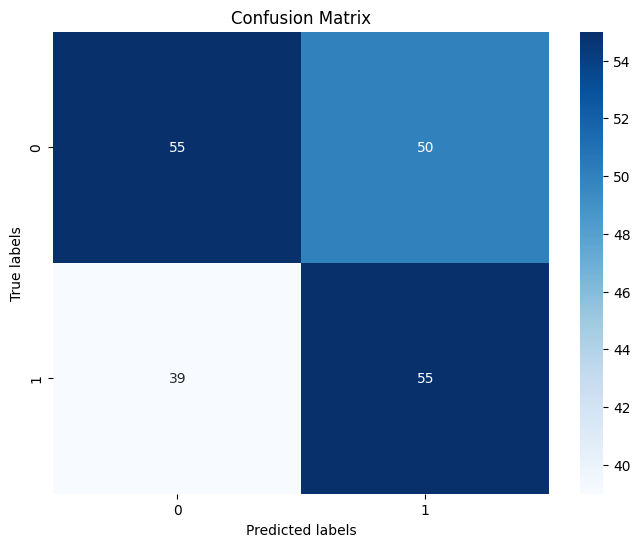

In [5]:
# Interpréter les prédictions
# création d'un objet contenant les photos
photos = []

for i in range(len(images)):
  image = images[i]
  prediction = predictions[i]
  binary_prediction = np.round(prediction)
  if binary_prediction == 1:
    photos.append(image)

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(labels, np.round(predictions))

# Afficher la matrice de confusion sous forme de heatmap avec seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Chemin du fichier d'annotations
annotation_file = "datasets/annotations/captions_train2014.json"

# Chemin du dossier contenant les images à annoter
PATH = 'datasets/train2014/'

# Lecture du fichier d'annotation
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Grouper toutes les annotations ayant le même identifiant.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  # Marquer le début et la fin de chaque annotation
  caption = f"<start> {val['caption']} <end>"
  # L'identifiant d'une image fait partie de son chemin d'accès
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  # Rajout du caption associé à image_path
  image_path_to_caption[image_path].append(caption)

# Prendre les premières images seulement
image_paths = list(image_path_to_caption.keys())
train_image_paths = image_paths[:2000]

# Liste de toutes les annotations
train_captions = []
# Liste de tous les noms de fichiers des images dupliquées (en nombre d'annotations par image)
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  # Rajout de caption_list dans train_captions
  train_captions.extend(caption_list)
  # Rajout de image_path dupliquée len(caption_list) fois
  img_name_vector.extend([image_path] * len(caption_list))


In [6]:
# Téléchargement du modèle InceptionV3 pré-entrainé avec la classification sur ImageNet
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Création d'une variable qui sera l'entrée du nouveau modèle de pré-traitement d'images
new_input = image_model.input

# Récupérer la dernière couche cachée qui contient l'image en représentation compacte
hidden_layer = image_model.layers[-1].output

# Modèle qui calcule une représentation dense des images avec InceptionV3
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [7]:
# Définition de la fonction load_image
def load_image(image_path):
  """
  La fonction load_image a pour entrée le chemin d'une image et pour sortie un couple
  contenant l'image traitée ainsi que son chemin d'accès.
  La fonction load_image effectue les traitements suivants:
  1. Chargement du fichier correspondant au chemin d'accès image_path
  2. Décodage de l'image en RGB.
  3. Redimensionnement de l'image en taille (299, 299).
  4. Normalisation des pixels de l'image entre -1 et 1
  """
  img = tf.io.read_file(image_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (256, 256))
  img = tf.keras.applications.inception_v3.preprocess_input(img)

  return img, image_path

In [12]:
# entrainement
# Pré-traitement des images
# Prendre les noms des images
encode_train = sorted(set(img_name_vector))

# Création d'une instance de "tf.data.Dataset" partant des noms des images
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

# Division des données en batchs après application du pré-traitement fait par load_image
image_dataset = image_dataset.map(
load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Parcourir le dataset batch par batch pour effectuer le pré-traitement d'InceptionV3
for img, path in tqdm(image_dataset):
  # Pré-traitement du batch (de taille (16, 8, 8, 2048)) courant par InceptionV3
  batch_features = image_features_extract_model(img)
  # Resize du batch de taille (16, 8, 8, 2048) en taille (16, 64, 2048)
  batch_features = tf.reshape(batch_features,
  (batch_features.shape[0], -1, batch_features.shape[3]))
  # Parcourir le batch courant et stocker le chemin ainsi que le batch avec np.save()
  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    # (chemin de l'image associé à sa nouvelle représentation, représentation de l'image)
    np.save(path_of_feature, bf.numpy())

100%|██████████| 125/125 [00:40<00:00,  3.05it/s]


In [13]:
# Trouver la taille maximale
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Chosir les 5000 mots les plus frequents du vocabulaire
top_k = 5000
#La classe Tokenizer permet de faire du pre-traitement de texte pour reseau de neurones
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
# Construit un vocabulaire en se basant sur la liste train_captions
tokenizer.fit_on_texts(train_captions)

# Créer le token qui sert à remplir les annotations pour égaliser leurs longueurs
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

# Création des vecteurs (liste de token entiers) à partir des annotations (liste de mots)
train_seqs = tokenizer.texts_to_sequences(train_captions)

# Remplir chaque vecteur jusqu'à la longueur maximale des annotations
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calcule la longueur maximale qui est utilisée pour stocker les poids d'attention
# Elle servira plus tard pour l'affichage lors de l'évaluation
max_length = calc_max_length(train_seqs)

In [14]:
img_to_cap_vector = collections.defaultdict(list)
# Creation d'un dictionnaire associant les chemins des images avec (fichier .npy) aux annotationss
# Les images sont dupliquées car il y a plusieurs annotations par image
print(len(img_name_vector), len(cap_vector))
for img, cap in zip(img_name_vector, cap_vector):
    img_to_cap_vector[img].append(cap)

"""
Création des datasets de formation et de validation en utilisant
un fractionnement 80-20 de manière aléatoire
"""
# Prendre les clés (noms des fichiers d'images traites), *celles-ci ne seront pas dupliquées*
img_keys = list(img_to_cap_vector.keys())
# Diviser des indices en entrainement et test
slice_index = int(len(img_keys) * 0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

"""
Les jeux d'entrainement et de tests sont sous forme
de listes contenants les mappings :(image prétraitée ---> jeton d'annotation(mot) )
"""

# Boucle pour construire le jeu d'entrainement
img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
    capt_len = len(img_to_cap_vector[imgt])
    # Duplication des images en le nombre d'annotations par image
    img_name_train.extend([imgt] * capt_len)
    cap_train.extend(img_to_cap_vector[imgt])

# Boucle pour construire le jeu de test
img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  # Duplication des images en le nombre d'annotations par image
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

10005 10005


(8004, 8004, 2001, 2001)

In [15]:
# N'hésitez pas à modifier ces paramètres en fonction de votre machine
BATCH_SIZE = 32 # taille du batch
BUFFER_SIZE = 1000 # taille du buffer pour melanger les donnes
embedding_dim = 256
units = 512 # Taille de la couche caché dans le RNN
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE

# La forme du vecteur extrait à partir d'InceptionV3 est (64, 2048)
# Les deux variables suivantes representent la forme de ce vecteur
features_shape = 2048
attention_features_shape = 64

# Fonction qui charge les fichiers numpy des images prétraitées
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

# Creation d'un dataset de "Tensor"s (sert à representer de grands dataset)
# Le dataset est cree a partir de "img_name_train" et "cap_train"
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# L'utilisation de map permet de charger les fichiers numpy (possiblement en parallèle)
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Melanger les donnees et les diviser en batchs
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [16]:
class CNN_Encoder(tf.keras.Model):
  def __init__(self, embedding_dim):
    super(CNN_Encoder, self).__init__()
    # Couche dense pour réduire la dimensionnalité des caractéristiques d'entrée
    self.fc = tf.keras.layers.Dense(embedding_dim)

  def call(self, x):
    # Réduire les caractéristiques spatiales en calculant la moyenne sur la deuxième dimension
    x = tf.reduce_mean(x, axis=1)
    # Passer les caractéristiques à travers la couche dense
    x = self.fc(x)
    # Appliquer la fonction d'activation ReLU
    x = tf.keras.activations.relu(x)
    return x

In [17]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)  # Couche dense pour les poids W1
    self.W2 = tf.keras.layers.Dense(units)  # Couche dense pour les poids W2
    self.V = tf.keras.layers.Dense(1)       # Couche dense pour les poids V

  def call(self, features, hidden):
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
    attention_weights = tf.nn.softmax(self.V(score), axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

In [18]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
    return_sequences=True,
    return_state=True,
    recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size, kernel_initializer='glorot_uniform')
    self.attention = BahdanauAttention(self.units)  # Ajoutez cette ligne pour initialiser l'attribut attention

  def call(self, x, hidden, enc_output):
    x = self.embedding(x)
    attention_result, attention_weights = self.attention(enc_output, hidden)
    x = tf.concat([tf.expand_dims(attention_result, 1), x], axis=-1)
    output, state = self.gru(x)
    output = tf.reshape(output, (-1, output.shape[2]))
    x = self.fc(output)
    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [19]:
# Création de l'encodeur
encoder = CNN_Encoder(embedding_dim)

# Création du décodeur
decoder = RNN_Decoder(embedding_dim, units, vocab_size)


In [20]:
# Optimiseur ADAM
optimizer = tf.keras.optimizers.Adam()

# La fonction de perte
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [21]:
checkpoint_path = "/content/drive/MyDrive/Models/Checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [22]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # Restaurer le dernier checkpoint dans checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

In [57]:
loss_plot = []
@tf.function
def train_step(img_tensor, target):
    loss = 0
    total_predictions = 0
    correct_predictions = 0

    # Initialisation de l'état caché pour chaque batch
    hidden = decoder.reset_state(batch_size=target.shape[0])

    # Initialiser l'entrée du décodeur
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape: # Offre la possibilité de calculer le gradient du loss
        features = encoder(img_tensor)

        for i in range(1, target.shape[1]):
            # Prédiction des i'èmes mot du batch avec le décodeur
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)

            # Calcul de l'accuracy
            total_predictions += predictions.shape[0]
            predicted_ids = tf.argmax(predictions, axis=-1)
            predicted_ids = tf.cast(predicted_ids, tf.int32)
            target_i = tf.cast(target[:, i], tf.int32)
            correct_predictions += tf.reduce_sum(tf.cast(tf.equal(predicted_ids, target_i), tf.float32))

            # Le mot correct à l'étape i est donné en entrée à l'étape (i+1)
            dec_input = tf.expand_dims(target[:, i], 1)

    accuracy = correct_predictions / total_predictions
    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss, accuracy

Epoch 1 Batch 0 Loss 2.9441 Accuracy 0.0000
Epoch 1 Batch 100 Loss 1.8808 Accuracy 0.0859
Epoch 1 Batch 200 Loss 1.6943 Accuracy 0.1162
Epoch 1 Loss 1.729027 Accuracy 0.0866
Time taken for 1 epoch 94.03055596351624 sec

Epoch 2 Batch 0 Loss 1.4415 Accuracy 0.1064
Epoch 2 Batch 100 Loss 1.3293 Accuracy 0.1221
Epoch 2 Batch 200 Loss 1.3730 Accuracy 0.1064
Epoch 2 Loss 1.406193 Accuracy 0.1171
Time taken for 1 epoch 24.524529695510864 sec

Epoch 3 Batch 0 Loss 1.4139 Accuracy 0.1221
Epoch 3 Batch 100 Loss 1.2688 Accuracy 0.1162
Epoch 3 Batch 200 Loss 1.2653 Accuracy 0.1230
Epoch 3 Loss 1.298473 Accuracy 0.1263
Time taken for 1 epoch 23.978692531585693 sec

Epoch 4 Batch 0 Loss 1.1565 Accuracy 0.1143
Epoch 4 Batch 100 Loss 1.1490 Accuracy 0.1338
Epoch 4 Batch 200 Loss 1.2021 Accuracy 0.1260
Epoch 4 Loss 1.230610 Accuracy 0.1311
Time taken for 1 epoch 24.12383008003235 sec

Epoch 5 Batch 0 Loss 1.1376 Accuracy 0.1299
Epoch 5 Batch 100 Loss 1.2002 Accuracy 0.1338
Epoch 5 Batch 200 Loss 1.157

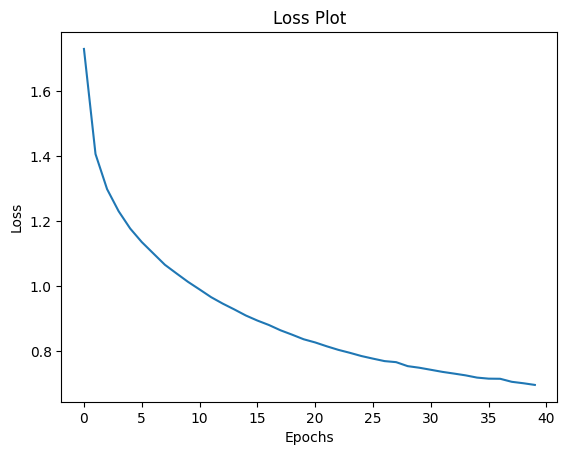

In [58]:
EPOCHS = 40

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    total_accuracy = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss, acc = train_step(img_tensor, target)
        total_loss += t_loss
        total_accuracy += acc

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
                            epoch + 1, batch, batch_loss.numpy() / int(target.shape[1]), acc))
    avg_accuracy = total_accuracy / (batch + 1)
    # sauvegarde de la perte
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
        ckpt_manager.save()

    print ('Epoch {} Loss {:.6f} Accuracy {:.4f}'.format(epoch + 1,
                                             total_loss/num_steps, avg_accuracy))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

# Affichage de la courbe d'entrainement
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [23]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    if type(image) == str:
      temp_input = tf.expand_dims(load_image(image)[0], 0)
    else:
      temp_input = image
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

# Fonction permettant la représentation de l'attention au niveau de l'image
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> a very young infant laying on a bed <end>
Prediction Caption: a very funky wildly decorated room with a pot and bathtub and toilet area <end>


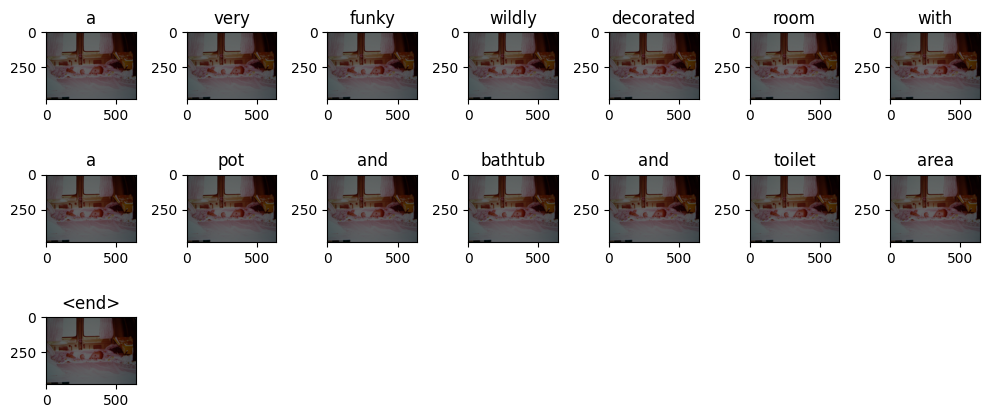

In [84]:
# Affichage de quelques annotations dans le jeu de test
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

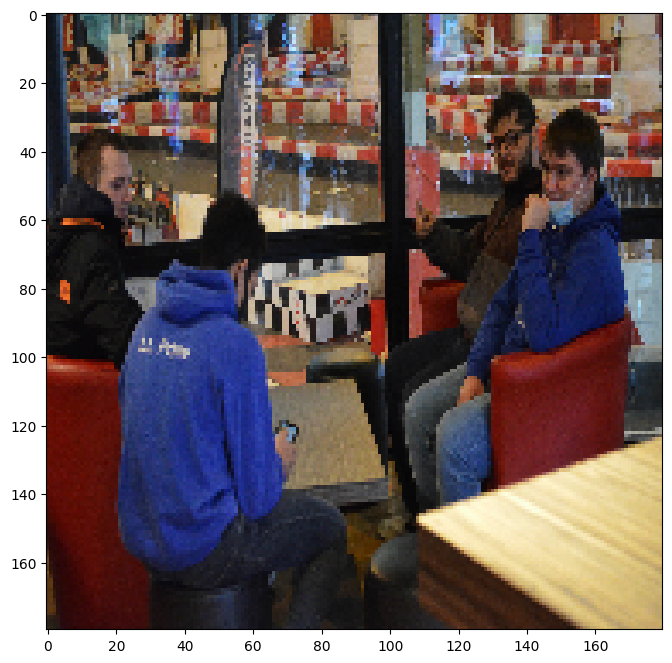

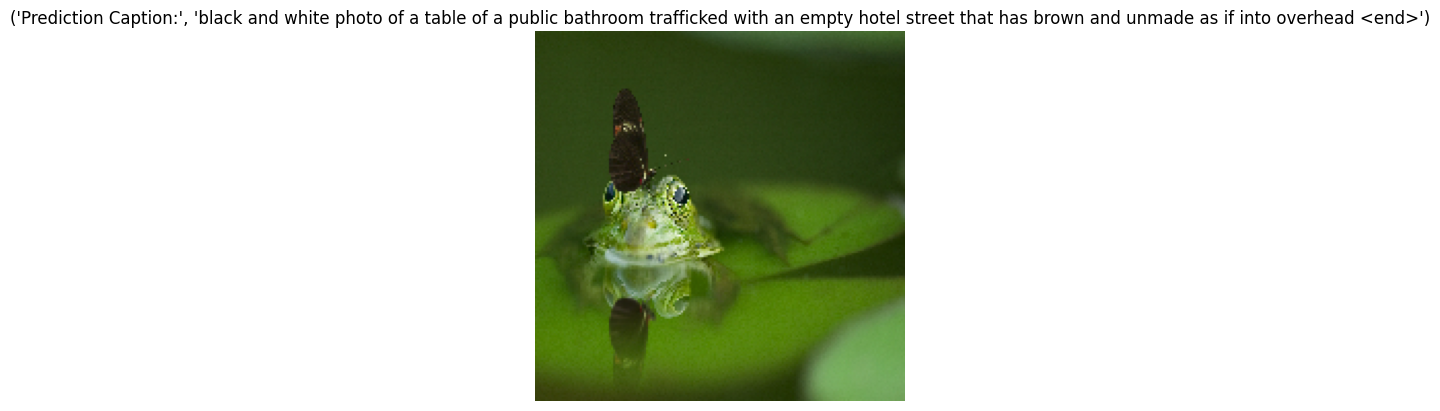

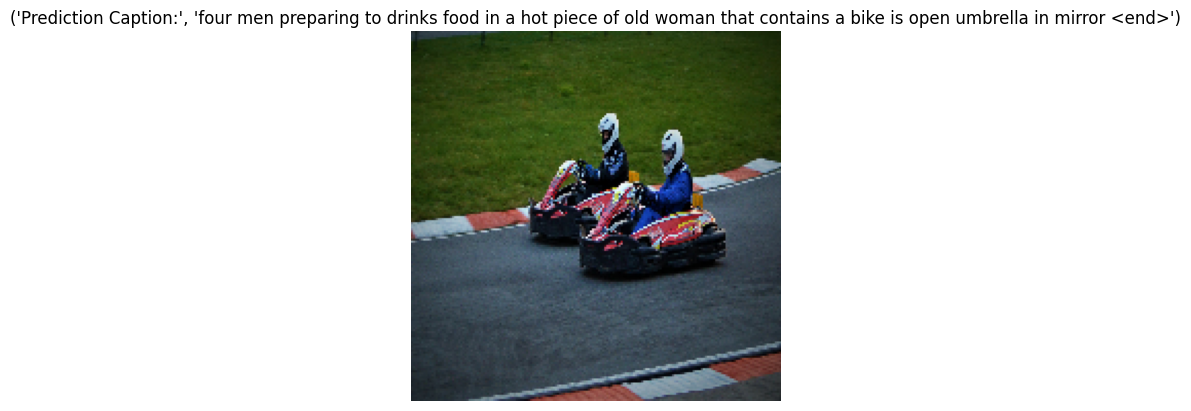

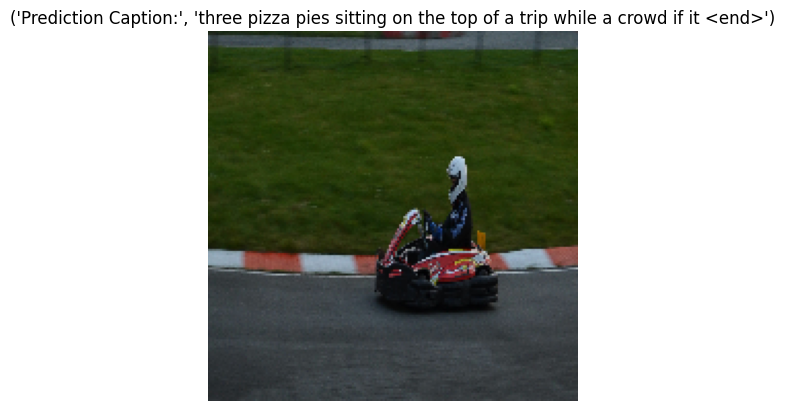

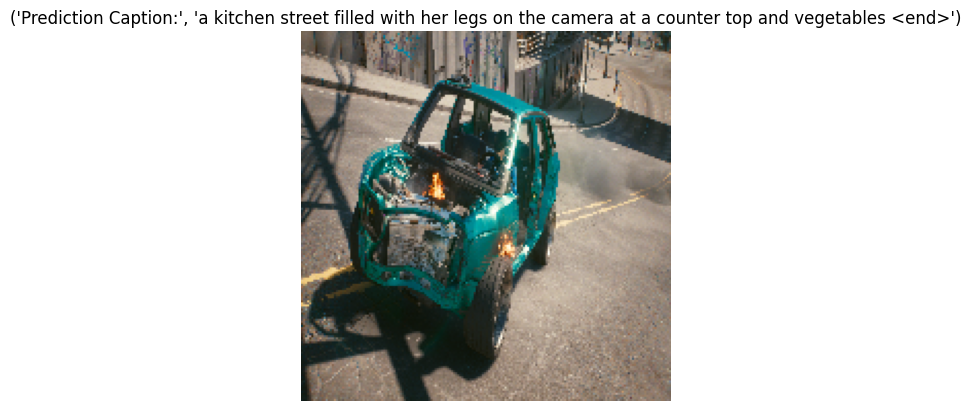

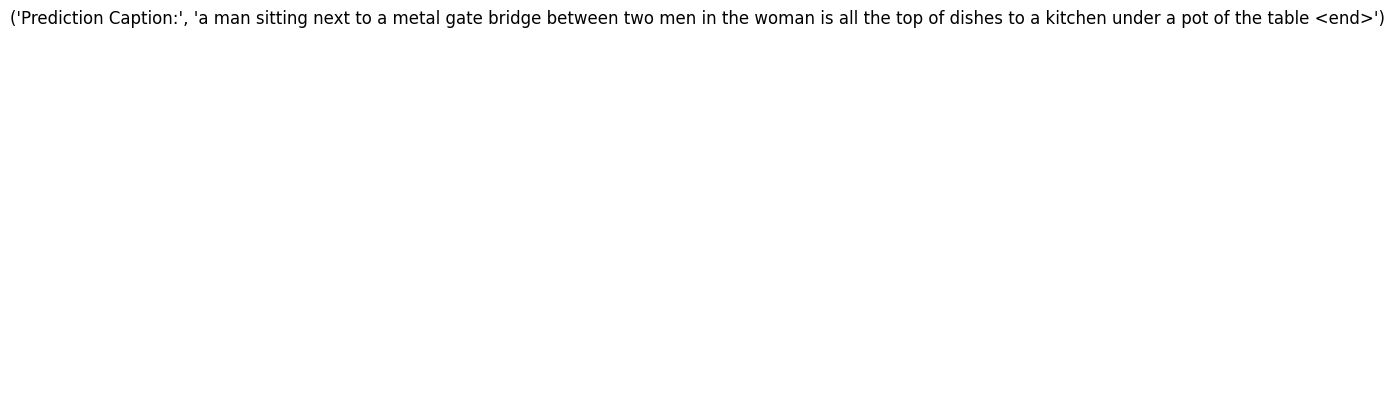

In [24]:
plt.figure(figsize=(8, 8))
# Création d'une instance de "tf.data.Dataset" partant des noms des images
photo_set = tf.data.Dataset.from_tensor_slices(photos)

for i in range(51, 56):
  photo = tf.expand_dims(photos[i] / 255, 0)
  result, attention_plot = evaluate(photo)
  caption = 'Prediction Caption:', ' '.join(result)
  plt.imshow(photos[i] / 255)
  plt.show()
  plt.title(caption)
  plt.axis("off")